## 今天的範例，帶大家如何操作與觀察 KNN 的補值效果

In [1]:
# library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import math
import statistics
import seaborn as sns
from IPython.display import display
import sklearn
print(sklearn.__version__)
#如果只有 0.19 記得要更新至 最新版本
%matplotlib inline


0.23.1


## 產生一組資料集

In [2]:
#用字典產生一組資料
data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
     'age':[23,40,5,30,1,40,16,27,43,8],
     'height':[180,170,100,176,70,160,170,166,155,np.NAN],
     'weight':[100,68,20,np.NAN,10,np.NAN,50,58,58,17]}
#轉成 dataframe格式 
data=pd.DataFrame(data)
display(data)

,sex,age,height,weight
0,Male,23,180.0,100.0
1,Male,40,170.0,68.0
2,Male,5,100.0,20.0
3,Male,30,176.0,NaN
4,Male,1,70.0,10.0
5,Female,40,160.0,NaN
6,Female,16,170.0,50.0
7,Female,27,166.0,58.0
8,Female,43,155.0,58.0
9,Female,8,NaN,17.0


In [3]:
#計算每一行是否有遺失值，計算遺失比例
missing_vals = data.isnull().sum()/len(data)
missing_vals.sort_values(ascending=False)
missing_vals = pd.DataFrame(missing_vals,columns=['missing_rate'])
print(missing_vals)

        missing_rate
sex              0.0
age              0.0
height           0.1
weight           0.2


### 身高和體重上，有遺失值
### 性別和年紀，沒有遺失值

## 觀察資料

### 身高和性別的關係

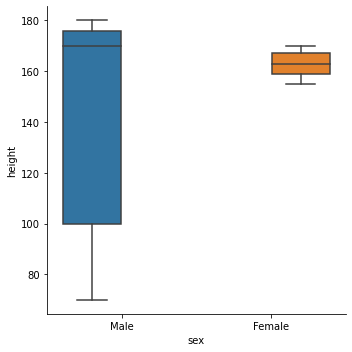

In [4]:
g = sns.catplot(x="sex", y="height", hue="sex",
               data=data,kind="box")
#男生女生的身高特性有差異

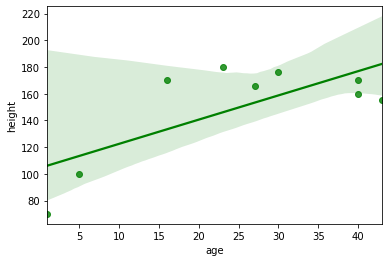

In [5]:
g = sns.regplot(x="age", y="height", color="g",data=data)
#年齡和身高有關連

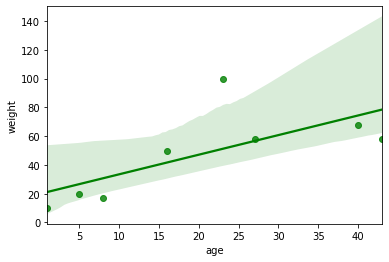

In [6]:
g = sns.regplot(x="age", y="weight", color="g",data=data)
#體重和年紀也有關聯

### 觀察到體重和身高 與年齡和性別，在圖形上觀察到有相關性
* 進階補值策略，就是取有相關的變數，估計遺失值。
* 今天課程中，採用 KNN 的演算法來補值

## 探索已知

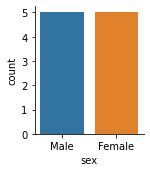

In [7]:
#男生女生個數
g = sns.catplot("sex",
                data=data,
                kind="count", height=2.5, aspect=.8)

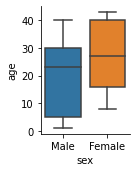

In [8]:
#男生女生中年齡分布
g = sns.catplot("sex",'age',
                data=data,
                kind="box", height=2.5, aspect=.8)
#發現男生女生都有小孩族群

In [9]:
# 細看遺失資料的樣態
missing_index=data.isnull()
display(data[missing_index.values==True])

,sex,age,height,weight
3,Male,30,176.0,NaN
5,Female,40,160.0,NaN
9,Female,8,NaN,17.0


### 遺失
* 身高: (女性,年齡 8歲,體重 17)
* 體重: (女性，年齡 40,身高 160),(男性，年齡 30,身高 176)

In [10]:
# 方法 1 : 用平均數補值補身高
data['height']=data['height'].fillna(data['height'].mean())
display(data)


,sex,age,height,weight
0,Male,23,180.000000,100.0
1,Male,40,170.000000,68.0
2,Male,5,100.000000,20.0
3,Male,30,176.000000,NaN
4,Male,1,70.000000,10.0
5,Female,40,160.000000,NaN
6,Female,16,170.000000,50.0
7,Female,27,166.000000,58.0
8,Female,43,155.000000,58.0
9,Female,8,149.666667,17.0


In [11]:
# 方法 1 : 用平均數補值補體重
data['weight']=data['weight'].fillna(data['weight'].mean())
display(data)
# 觀察到用平均數補值，效果沒有那麼好。

,sex,age,height,weight
0,Male,23,180.000000,100.000
1,Male,40,170.000000,68.000
2,Male,5,100.000000,20.000
3,Male,30,176.000000,47.625
4,Male,1,70.000000,10.000
5,Female,40,160.000000,47.625
6,Female,16,170.000000,50.000
7,Female,27,166.000000,58.000
8,Female,43,155.000000,58.000
9,Female,8,149.666667,17.000


# 透過 KNN 來補值
## 調整不同參數的效果

### K=1,weights= uniform

In [14]:
ori_data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
     'age':[23,40,5,30,1,40,16,27,43,8],
     'height':[180,170,100,176,70,160,170,166,155,np.NAN],
     'weight':[100,68,20,np.NAN,10,np.NAN,50,58,58,17]}
 
ori_data=pd.DataFrame(ori_data)
display(ori_data)

,sex,age,height,weight
0,Male,23,180.0,100.0
1,Male,40,170.0,68.0
2,Male,5,100.0,20.0
3,Male,30,176.0,NaN
4,Male,1,70.0,10.0
5,Female,40,160.0,NaN
6,Female,16,170.0,50.0
7,Female,27,166.0,58.0
8,Female,43,155.0,58.0
9,Female,8,NaN,17.0


### Step1:  離散轉連續型資料

In [15]:
data=ori_data.copy() #複製一份資料給 data
#ValueError: could not convert string to float: 'Male', sklearn 中的 KNN 只能處理數值型態
#轉型 
#透過 preprocessing 轉換
from sklearn import preprocessing
#下面兩行程式，讓 Male=1, FeMale=0.
le = preprocessing.LabelEncoder()
data['sex']=le.fit_transform(data['sex'])
display(data)

,sex,age,height,weight
0,1,23,180.0,100.0
1,1,40,170.0,68.0
2,1,5,100.0,20.0
3,1,30,176.0,NaN
4,1,1,70.0,10.0
5,0,40,160.0,NaN
6,0,16,170.0,50.0
7,0,27,166.0,58.0
8,0,43,155.0,58.0
9,0,8,NaN,17.0


### Step 2 :計算資料點的倆倆距離

In [16]:
from sklearn.metrics.pairwise import nan_euclidean_distances
display(pd.DataFrame(nan_euclidean_distances(data)))
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.nan_euclidean_distances.html?highlight=nan_euclidean

#所以從這各表中，我們可以發現 第九個位置的點，和 2 最接近。

,0,1,2,3,4,5,6,7,8,9
0,0.000000,37.589892,114.560028,9.309493,143.819331,30.331502,51.478151,44.463468,52.820451,97.399521
1,37.589892,0.000000,91.809586,13.466007,122.004098,11.604597,30.016662,16.911535,18.303005,69.531767
2,114.560028,91.809586,0.000000,92.383260,31.874755,80.216374,76.954532,79.277992,76.902536,5.033223
3,9.309493,13.466007,92.383260,0.000000,126.896283,21.817424,17.625739,12.110601,28.542366,31.144823
4,143.819331,122.004098,31.874755,126.896283,0.000000,113.266647,108.747414,110.440029,106.273233,11.489125
5,30.331502,11.604597,80.216374,21.817424,113.266647,0.000000,30.022214,16.532796,6.733003,45.254834
6,51.478151,30.016662,76.954532,17.625739,108.747414,30.022214,0.000000,14.177447,31.906112,39.208843
7,44.463468,16.911535,79.277992,12.110601,110.440029,16.532796,14.177447,0.000000,19.416488,52.179178
8,52.820451,18.303005,76.902536,28.542366,106.273233,6.733003,31.906112,19.416488,0.000000,62.246821
9,97.399521,69.531767,5.033223,31.144823,11.489125,45.254834,39.208843,52.179178,62.246821,0.000000


## Step3: 透過 KNN 進行補值

In [17]:
# KNN
# 設定 k 值
value_neighbors=1
from sklearn.impute import KNNImputer
#初始化: Initialize KNNImputer
imputer = KNNImputer(n_neighbors=value_neighbors)
df_filled = pd.DataFrame(imputer.fit_transform(data))
#display(data[missing_index.values==True])
#display(df_filled[missing_index.values==True])
display(df_filled)

,0,1,2,3
0,1.0,23.0,180.0,100.0
1,1.0,40.0,170.0,68.0
2,1.0,5.0,100.0,20.0
3,1.0,30.0,176.0,100.0
4,1.0,1.0,70.0,10.0
5,0.0,40.0,160.0,58.0
6,0.0,16.0,170.0,50.0
7,0.0,27.0,166.0,58.0
8,0.0,43.0,155.0,58.0
9,0.0,8.0,100.0,17.0


## K=3,weights= uniform

In [77]:
#data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
#     'age':[23,40,5,30,1,40,16,27,43,8],
#     'height':[180,170,100,176,70,160,170,166,155,np.NAN],
#     'weight':[100,68,20,np.NAN,10,np.NAN,50,58,58,17]}
# 
#data=pd.DataFrame(data)
#display(data)

In [18]:
data=ori_data.copy() #複製一份資料給 data
#轉型 
#透過 preprocessing 轉換

from sklearn import preprocessing
#下面兩行程式，讓 Male=1, FeMale=0.

le = preprocessing.LabelEncoder()
data['sex']=le.fit_transform(data['sex'])
print(data['sex'])
# KNN
value_neighbors=3
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=value_neighbors)
df_filled = pd.DataFrame(imputer.fit_transform(data))
#display(data[missing_index.values==True])
#display(df_filled[missing_index.values==True])
display(df_filled)

0    1
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: sex, dtype: int32


,0,1,2,3
0,1.0,23.0,180.000000,100.000000
1,1.0,40.0,170.000000,68.000000
2,1.0,5.0,100.000000,20.000000
3,1.0,30.0,176.000000,75.333333
4,1.0,1.0,70.000000,10.000000
5,0.0,40.0,160.000000,61.333333
6,0.0,16.0,170.000000,50.000000
7,0.0,27.0,166.000000,58.000000
8,0.0,43.0,155.000000,58.000000
9,0.0,8.0,115.333333,17.000000


## K=1,weights= distance
*由於 k=1 ，看不出 weights 的效果

In [79]:
#data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
#     'age':[23,40,5,30,1,40,16,27,43,8],
#     'height':[180,170,100,176,70,160,170,166,155,np.NAN],
#     'weight':[100,68,20,np.NAN,10,np.NAN,50,58,58,17]}
# 
#data=pd.DataFrame(data)
#display(data)

In [80]:
data=ori_data.copy() #複製一份資料給 data
#轉型 
#透過 preprocessing 轉換
from sklearn import preprocessing
#下面兩行程式，讓 Male=1, FeMale-0.
#le = preprocessing.LabelEncoder()
data['sex']=le.fit_transform(data['sex'])
print(data['sex'])
# KNN
value_neighbors=1
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=value_neighbors,weights='distance')
df_filled = pd.DataFrame(imputer.fit_transform(data))
#display(data[missing_index.values==True])
#display(df_filled[missing_index.values==True])
display(df_filled)

0    1
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: sex, dtype: int32


,0,1,2,3
0,1.0,23.0,180.0,100.0
1,1.0,40.0,170.0,68.0
2,1.0,5.0,100.0,20.0
3,1.0,30.0,176.0,100.0
4,1.0,1.0,70.0,10.0
5,0.0,40.0,160.0,58.0
6,0.0,16.0,170.0,50.0
7,0.0,27.0,166.0,58.0
8,0.0,43.0,155.0,58.0
9,0.0,8.0,100.0,17.0


## K=3,weights= distance

In [19]:
#data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
#     'age':[23,40,5,30,1,40,16,27,43,8],
#     'height':[180,170,100,176,70,160,170,166,155,np.NAN],
#     'weight':[100,68,20,np.NAN,10,np.NAN,50,58,58,17]}
 
#data=pd.DataFrame(data)
data=ori_data.copy() #複製一份資料給 data

#轉型 
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['sex']=le.fit_transform(data['sex'])
print(data['sex'])
# KNN
value_neighbors=3
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=value_neighbors,weights='distance')
df_filled = pd.DataFrame(imputer.fit_transform(data))
#display(data[missing_index.values==True])
#display(df_filled[missing_index.values==True])
display(df_filled)

0    1
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: sex, dtype: int32


,0,1,2,3
0,1.0,23.0,180.000000,100.000000
1,1.0,40.0,170.000000,68.000000
2,1.0,5.0,100.000000,20.000000
3,1.0,30.0,176.000000,77.883152
4,1.0,1.0,70.000000,10.000000
5,0.0,40.0,160.000000,60.919322
6,0.0,16.0,170.000000,50.000000
7,0.0,27.0,166.000000,58.000000
8,0.0,43.0,155.000000,58.000000
9,0.0,8.0,99.462122,17.000000


## add indicator = 'true' 的差異 

In [82]:
#data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
#     'age':[23,40,5,30,1,40,16,27,43,8],
#     'height':[180,170,100,176,70,160,170,166,155,np.NAN],
#     'weight':[100,68,20,np.NAN,10,np.NAN,50,58,58,17]}
 
#data=pd.DataFrame(data)
#display(data)

In [20]:
data=ori_data.copy() #複製一份資料給 data
#轉型 
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['sex']=le.fit_transform(data['sex'])
print(data['sex'])
# KNN
value_neighbors=2
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=value_neighbors,add_indicator= True)
df_filled = pd.DataFrame(imputer.fit_transform(data))
#display(data[missing_index.values==True])
#display(df_filled[missing_index.values==True])
display(df_filled)


0    1
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: sex, dtype: int32


,0,1,2,3,4,5
0,1.0,23.0,180.0,100.0,0.0,0.0
1,1.0,40.0,170.0,68.0,0.0,0.0
2,1.0,5.0,100.0,20.0,0.0,0.0
3,1.0,30.0,176.0,79.0,0.0,1.0
4,1.0,1.0,70.0,10.0,0.0,0.0
5,0.0,40.0,160.0,63.0,0.0,1.0
6,0.0,16.0,170.0,50.0,0.0,0.0
7,0.0,27.0,166.0,58.0,0.0,0.0
8,0.0,43.0,155.0,58.0,0.0,0.0
9,0.0,8.0,85.0,17.0,1.0,0.0


多了後面兩行，分別代表， hight 那些地方有補值為1， weight 那些地方有補值為1

## sex 類別-  類別資料轉換對於 KNN 的影響

In [84]:
#data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
#     'age':[23,40,5,30,1,40,16,27,43,8],
#     'height':[180,170,100,176,70,160,170,166,155,np.NAN],
#     'weight':[100,68,20,np.NAN,10,np.NAN,50,58,58,17]}
# 
#data=pd.DataFrame(data)
#display(data)

In [21]:
data=ori_data.copy() #複製一份資料給 data
#print(data['age','height','weight'])
#ValueError: could not convert string to float: 'Male', sklearn 中的 KNN 只能處理數值型態
#假設我想以女生的資料，補女生的身高體重，男生的資料補男生的身高體重?

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['sex']=le.fit_transform(data['sex'])
# KNN
value_neighbors=1
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=value_neighbors)
df_filled = pd.DataFrame(imputer.fit_transform(data))
#display(data[missing_index.values==True])
display(df_filled)

,0,1,2,3
0,1.0,23.0,180.0,100.0
1,1.0,40.0,170.0,68.0
2,1.0,5.0,100.0,20.0
3,1.0,30.0,176.0,100.0
4,1.0,1.0,70.0,10.0
5,0.0,40.0,160.0,58.0
6,0.0,16.0,170.0,50.0
7,0.0,27.0,166.0,58.0
8,0.0,43.0,155.0,58.0
9,0.0,8.0,100.0,17.0


In [86]:
#data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
#     'age':[23,40,5,30,1,40,16,27,43,8],
#     'height':[180,170,100,176,70,160,170,166,155,np.NAN],
#     'weight':[100,68,20,np.NAN,10,np.NAN,50,58,58,17]}
# 
#data=pd.DataFrame(data)
#display(data)

In [22]:
data=ori_data.copy() #複製一份資料給 data
data['sex'].replace({'Male': 0,'Female': 1000},inplace=True)
print(data['sex'])
# KNN
value_neighbors=1
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=value_neighbors)
df_filled = pd.DataFrame(imputer.fit_transform(data))
display(df_filled)

0       0
1       0
2       0
3       0
4       0
5    1000
6    1000
7    1000
8    1000
9    1000
Name: sex, dtype: int64


,0,1,2,3
0,0.0,23.0,180.0,100.0
1,0.0,40.0,170.0,68.0
2,0.0,5.0,100.0,20.0
3,0.0,30.0,176.0,100.0
4,0.0,1.0,70.0,10.0
5,1000.0,40.0,160.0,58.0
6,1000.0,16.0,170.0,50.0
7,1000.0,27.0,166.0,58.0
8,1000.0,43.0,155.0,58.0
9,1000.0,8.0,170.0,17.0


## 判斷補值的好壞?
可以運用模型預測準確度的指標，來判斷補值的好壞
* MSE代表均方誤差(Mean-Square Error)。即絕對誤差的平均值，來判斷，
MSE 越小代表補值的準確度越高。
還有其他的指標可以使用，在建立模型的課程中，會提到更多的指標。

* Step1:取無遺失值的資料集
* Step2:隨機取幾個資料點，當作遺失值
* Step3:以step2產生的遺失值進行補值，
* Step4: 計算MSE看補值的效果。



In [23]:
data=ori_data.copy() #複製一份資料給 data
from sklearn import preprocessing
#轉型 
le = preprocessing.LabelEncoder()
data['sex']=le.fit_transform(data['sex'])
print(data['sex'])
# KNN
value_neighbors=3
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=value_neighbors,add_indicator= True)


0    1
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: sex, dtype: int32


In [24]:
#* Step1:取無遺失值的資料集
import random
completet_data=data.dropna()
#重製index
completet_data=completet_data.reset_index(drop=True)
display(completet_data)

,sex,age,height,weight
0,1,23,180.0,100.0
1,1,40,170.0,68.0
2,1,5,100.0,20.0
3,1,1,70.0,10.0
4,0,16,170.0,50.0
5,0,27,166.0,58.0
6,0,43,155.0,58.0


In [25]:
#* Step2:隨機取 2 個資料點，當作遺失值
a = random.sample(list(completet_data.index),2) 
missing_data=completet_data.copy()
missing_data['height'].iloc[a]=np.nan
missing_data['weight'].iloc[a]=np.nan
display(missing_data)

C:\Users\LINDA YEH\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,sex,age,height,weight
0,1,23,NaN,NaN
1,1,40,NaN,NaN
2,1,5,100.0,20.0
3,1,1,70.0,10.0
4,0,16,170.0,50.0
5,0,27,166.0,58.0
6,0,43,155.0,58.0


In [26]:
#* Step3:以step2產生的遺失值進行補值
verify_impute = pd.DataFrame(imputer.fit_transform(missing_data))
verify_impute.rename(columns={0:'sex',1:'age',2:'height',3:'weight',4:'imputed_h',5:'imputed_w'},inplace=True)
display(verify_impute)

,sex,age,height,weight,imputed_h,imputed_w
0,1.0,23.0,145.333333,42.666667,1.0,1.0
1,1.0,40.0,163.666667,55.333333,1.0,1.0
2,1.0,5.0,100.000000,20.000000,0.0,0.0
3,1.0,1.0,70.000000,10.000000,0.0,0.0
4,0.0,16.0,170.000000,50.000000,0.0,0.0
5,0.0,27.0,166.000000,58.000000,0.0,0.0
6,0.0,43.0,155.000000,58.000000,0.0,0.0


In [27]:
display(completet_data)
display(verify_impute)

,sex,age,height,weight
0,1,23,180.0,100.0
1,1,40,170.0,68.0
2,1,5,100.0,20.0
3,1,1,70.0,10.0
4,0,16,170.0,50.0
5,0,27,166.0,58.0
6,0,43,155.0,58.0


,sex,age,height,weight,imputed_h,imputed_w
0,1.0,23.0,145.333333,42.666667,1.0,1.0
1,1.0,40.0,163.666667,55.333333,1.0,1.0
2,1.0,5.0,100.000000,20.000000,0.0,0.0
3,1.0,1.0,70.000000,10.000000,0.0,0.0
4,0.0,16.0,170.000000,50.000000,0.0,0.0
5,0.0,27.0,166.000000,58.000000,0.0,0.0
6,0.0,43.0,155.000000,58.000000,0.0,0.0


In [29]:
# 判斷 df_filled 和 data 的距離
# height
# weight
# Step4: 計算MSE看補值的效果，可以透過這一個方法，比較不同補植策略下 MSE 的大小。


from sklearn.metrics import mean_squared_error

y_true1 =completet_data['height']
y_pred1 = verify_impute['height']
MSE_h=mean_squared_error(y_true1, y_pred1)
print(MSE_h)

#這邊的 MSE1 很大的原因，
# 是因為和遺失值旁邊的資料點數不多，對於 KNN 而言資料量要夠多，補值的效果才會比較好。
# 每次 random 的效果不同，


y_true1 =completet_data['weight']
y_pred1 = verify_impute['weight']
MSE_h=mean_squared_error(y_true1, y_pred1)
print(MSE_h)

177.41269841269835
492.5079365079365
